In [1]:
from collectorSimulationHelperFunctions import build_collector_lattice,CollectorSwarmAnalyzer
from phaseSpaceAnalysis_Functions import transfer_particles_to_new_swarm
from SwarmTracerClass import SwarmTracer
import numpy as np
import matplotlib.pyplot as plt
import time
lattice=build_collector_lattice(interp_density_mult=4)
st=SwarmTracer(lattice)
%matplotlib inline
# lattice.show_lattice()

In [2]:
pr_max=1.1*lattice.speed_nominal*(5.0/72)
swarm_initial=st.initalize_pseudorandom_swarm_in_phase_space(1e-9,pr_max,1e-9,100_000,same_seed=True)
for particle in swarm_initial:
    particle.pi[0]*=-1
    particle.qi[0]+=5e-10

In [3]:
from ParticleClass import Swarm
T_max_sim=1.0
num_particles_sim=num_particles_left=len(swarm_initial)
work_size=100_000
swarm_traced=Swarm()
t=time.time()
while len(swarm_initial)>0:
    swarm_to_trace=transfer_particles_to_new_swarm(swarm_initial,work_size)
    print(len(swarm_initial))
    swarm_traced_small=st.trace_swarm_through_lattice(swarm_to_trace,5e-6,T_max_sim,parallel=True,use_fast_mode=True,accelerated=True)
    swarm_traced.particles.extend(swarm_traced_small.particles)
print(time.time()-t)

0
20.637022018432617


In [4]:
analyzer=CollectorSwarmAnalyzer(swarm_traced,lattice)

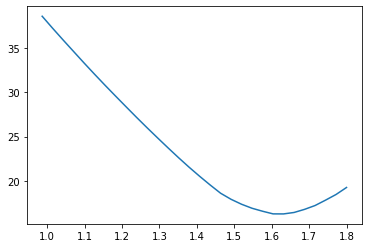

16.311313450627203

In [5]:
x_min,x_max=analyzer.end_drift_x_min_max()
x_vals=np.linspace(x_min+1e-3,1.8,30)
d90_vals=[analyzer.D_90(x) for x in x_vals]
plt.plot(x_vals,d90_vals)
plt.show()
np.min(d90_vals)

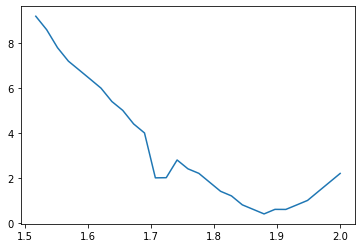

(0.40131571194518745, 1.8793103448275863)

In [24]:
x_vals=np.linspace(1.5,2.0,30)
r_max=10
fwhms=[ analyzer.fwhm(x,r_max,bins=50) for x in x_vals]
plt.plot(x_vals,fwhms)
plt.show()
np.nanmin(fwhms),x_vals[np.nanargmin(fwhms)]

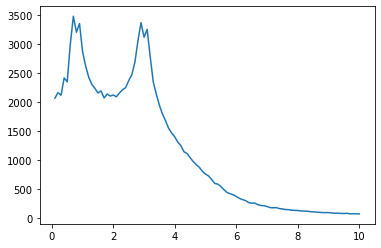

4.506033858776119

In [27]:
r_vals,density=analyzer.transvers_density(1.7,r_max,bins=100)
density_half=density[0]/2.0
FWHM=r_vals[np.argmin(np.abs(density-density_half))]
plt.plot(r_vals,density)
plt.show()
FWHM

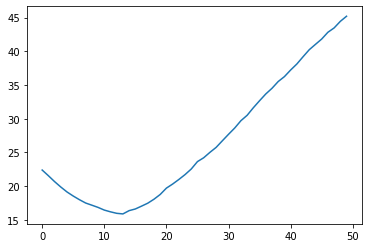

In [54]:
x_values=np.linspace(1.2,2.0)
vals=[analyzer.D_90(x) for x in x_values]
plt.plot(vals)
plt.show()